In [1]:
# Imports
import pathlib
import numpy as np
import torch
from skimage.io import imread
from skimage.transform import resize
from inference import predict
from transformations import normalize_01, re_normalize
from unet import UNet

# root directory
root = pathlib.Path.cwd() / "Lungs" / "Test"


def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    # Returns a list of files in a directory/path. Uses pathlib.
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
images_names = get_filenames_of_path(root / "Input")
targets_names = get_filenames_of_path(root / "Target")

# read images and store them in memory
images = [imread(img_name) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

# Resize images and targets
images_res = [resize(img, (128, 128, 3)) for img in images]
resize_kwargs = {"order": 0, "anti_aliasing": False, "preserve_range": True}
targets_res = [resize(tar, (128, 128), **resize_kwargs) for tar in targets]

In [2]:
# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Model initialization and weights loading

# model = UNet(
#     in_channels=3,
#     out_channels=2,
#     n_blocks=4,
#     start_filters=32,
#     activation="relu",
#     normalization="batch",
#     conv_mode="same",
#     dim=2,
# ).to(device)
#
# model_name = "carvana_model.pt"
# model_weights = torch.load(pathlib.Path.cwd() / model_name, map_location=device)
#
# model.load_state_dict(model_weights)

# Loading trained model

PATH = "entire_model.pt"
model = torch.load(PATH)

In [3]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

In [4]:
# predict the segmentation maps
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]

C:\Users\andrey.kurenkov\.conda\envs\torch_gpu\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


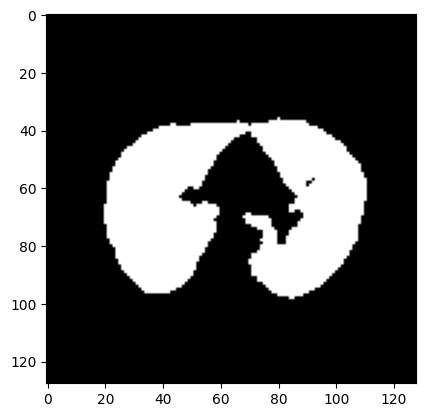

In [5]:
# plot one image from output
import matplotlib.pyplot as plt
plt.imshow(output[5], cmap="gray")

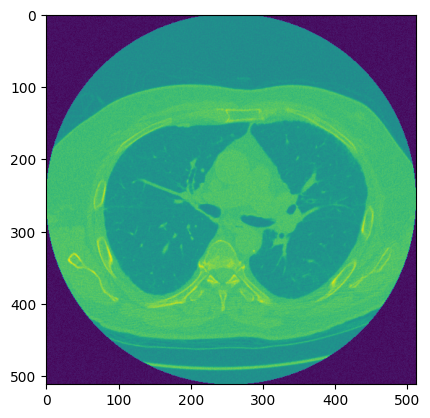

In [6]:
plt.imshow(images[5])

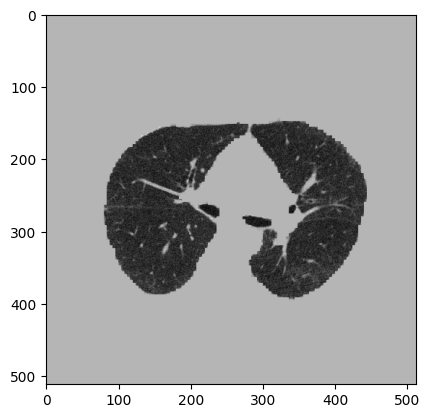

In [9]:
mask = output[5]
orig = images[5]
# resize mask to 512x512
mask_res = resize(mask, (512, 512), **resize_kwargs)
# in 'orig' leave only pixels that intersect with mask
orig[mask_res == 0] = 0
plt.imshow(orig, cmap="gray")

In [28]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# a function that will plot 3D scan image as surface
def plot_3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)
    verts, faces, _, _ = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

In [29]:
# make orig image a plane rotated 45 degrees in 3D
orig_3d = np.zeros((512, 512, 512))
orig_3d[256, :, :] = orig
orig_3d[:, 256, :] = orig
orig_3d[:, :, 256] = orig

(array([[  0.,   0.,   0., ..., 512.,   0.,   0.],
        [  0.,   0.,   0., ..., 512.,   0.,   0.],
        [  0.,   0.,   0., ..., 512.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ..., 512.,   0.,   0.],
        [  0.,   0.,   0., ..., 512.,   0.,   0.],
        [  0.,   0.,   0., ..., 512.,   0.,   0.]]),
 array([-940. , -807.1, -674.2, -541.3, -408.4, -275.5, -142.6,   -9.7,
         123.2,  256.1,  389. ]),
 <a list of 512 BarContainer objects>)

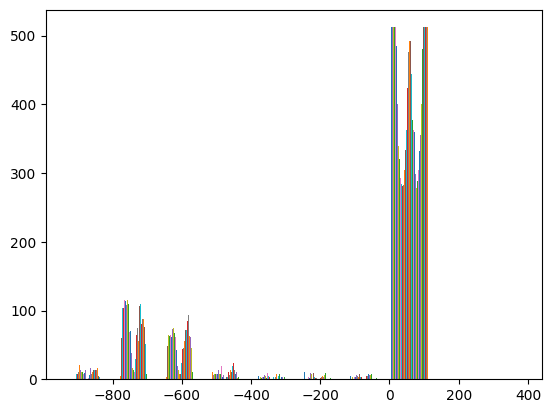

In [33]:
plt.hist(orig)